In [ ]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings('ignore')

In [2]:
pd.options.display.float_format = '{:.4f}'.format

In [3]:
laptop_data = pd.read_csv('../b. Datasets/Laptop Price Analysis/Laptop Price Analysis.csv')

In [4]:
display(laptop_data.head(2))
display(laptop_data.tail(2))

,Company,Product,TypeName,Inches,ScreenResolution,CPU_Company,CPU_Type,CPU_Frequency (GHz),RAM (GB),Memory,GPU_Company,GPU_Type,OpSys,Weight (kg),Price (Euro)
0,Apple,MacBook Pro,Ultrabook,13.3000,IPS Panel Retina Display 2560x1600,Intel,Core i5,2.3000,8,128GB SSD,Intel,Iris Plus Graphics 640,macOS,1.3700,1339.6900
1,Apple,Macbook Air,Ultrabook,13.3000,1440x900,Intel,Core i5,1.8000,8,128GB Flash Storage,Intel,HD Graphics 6000,macOS,1.3400,898.9400


,Company,Product,TypeName,Inches,ScreenResolution,CPU_Company,CPU_Type,CPU_Frequency (GHz),RAM (GB),Memory,GPU_Company,GPU_Type,OpSys,Weight (kg),Price (Euro)
1273,HP,15-AC110nv (i7-6500U/6GB/1TB/Radeon,Notebook,15.6000,1366x768,Intel,Core i7 6500U,2.5000,6,1TB HDD,AMD,Radeon R5 M330,Windows 10,2.1900,764.0000
1274,Asus,X553SA-XX031T (N3050/4GB/500GB/W10),Notebook,15.6000,1366x768,Intel,Celeron Dual Core N3050,1.6000,4,500GB HDD,Intel,HD Graphics,Windows 10,2.2000,369.0000


In [5]:
laptop_data.shape

(1275, 15)

In [6]:
laptop_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1275 entries, 0 to 1274
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Company              1275 non-null   object 
 1   Product              1275 non-null   object 
 2   TypeName             1275 non-null   object 
 3   Inches               1275 non-null   float64
 4   ScreenResolution     1275 non-null   object 
 5   CPU_Company          1275 non-null   object 
 6   CPU_Type             1275 non-null   object 
 7   CPU_Frequency (GHz)  1275 non-null   float64
 8   RAM (GB)             1275 non-null   int64  
 9   Memory               1275 non-null   object 
 10  GPU_Company          1275 non-null   object 
 11  GPU_Type             1275 non-null   object 
 12  OpSys                1275 non-null   object 
 13  Weight (kg)          1275 non-null   float64
 14  Price (Euro)         1275 non-null   float64
dtypes: float64(4), int64(1), object(10)
me

In [7]:
true_numerical_features = ['Inches', 'CPU_Frequency (GHz)', 'RAM (GB)', 'Weight (kg)', 'Price (Euro)']

In [8]:
laptop_data.describe()

,Inches,CPU_Frequency (GHz),RAM (GB),Weight (kg),Price (Euro)
count,1275.0000,1275.0000,1275.0000,1275.0000,1275.0000
mean,15.0229,2.3030,8.4408,2.0405,1134.9691
std,1.4295,0.5038,5.0978,0.6692,700.7525
min,10.1000,0.9000,2.0000,0.6900,174.0000
25%,14.0000,2.0000,4.0000,1.5000,609.0000
50%,15.6000,2.5000,8.0000,2.0400,989.0000
75%,15.6000,2.7000,8.0000,2.3100,1496.5000
max,18.4000,3.6000,64.0000,4.7000,6099.0000


In [9]:
laptop_data.isna().sum()

Company                0
Product                0
TypeName               0
Inches                 0
ScreenResolution       0
CPU_Company            0
CPU_Type               0
CPU_Frequency (GHz)    0
RAM (GB)               0
Memory                 0
GPU_Company            0
GPU_Type               0
OpSys                  0
Weight (kg)            0
Price (Euro)           0
dtype: int64

In [10]:
laptop_data.select_dtypes(include='number').std()

Inches                  1.4295
CPU_Frequency (GHz)     0.5038
RAM (GB)                5.0978
Weight (kg)             0.6692
Price (Euro)          700.7525
dtype: float64

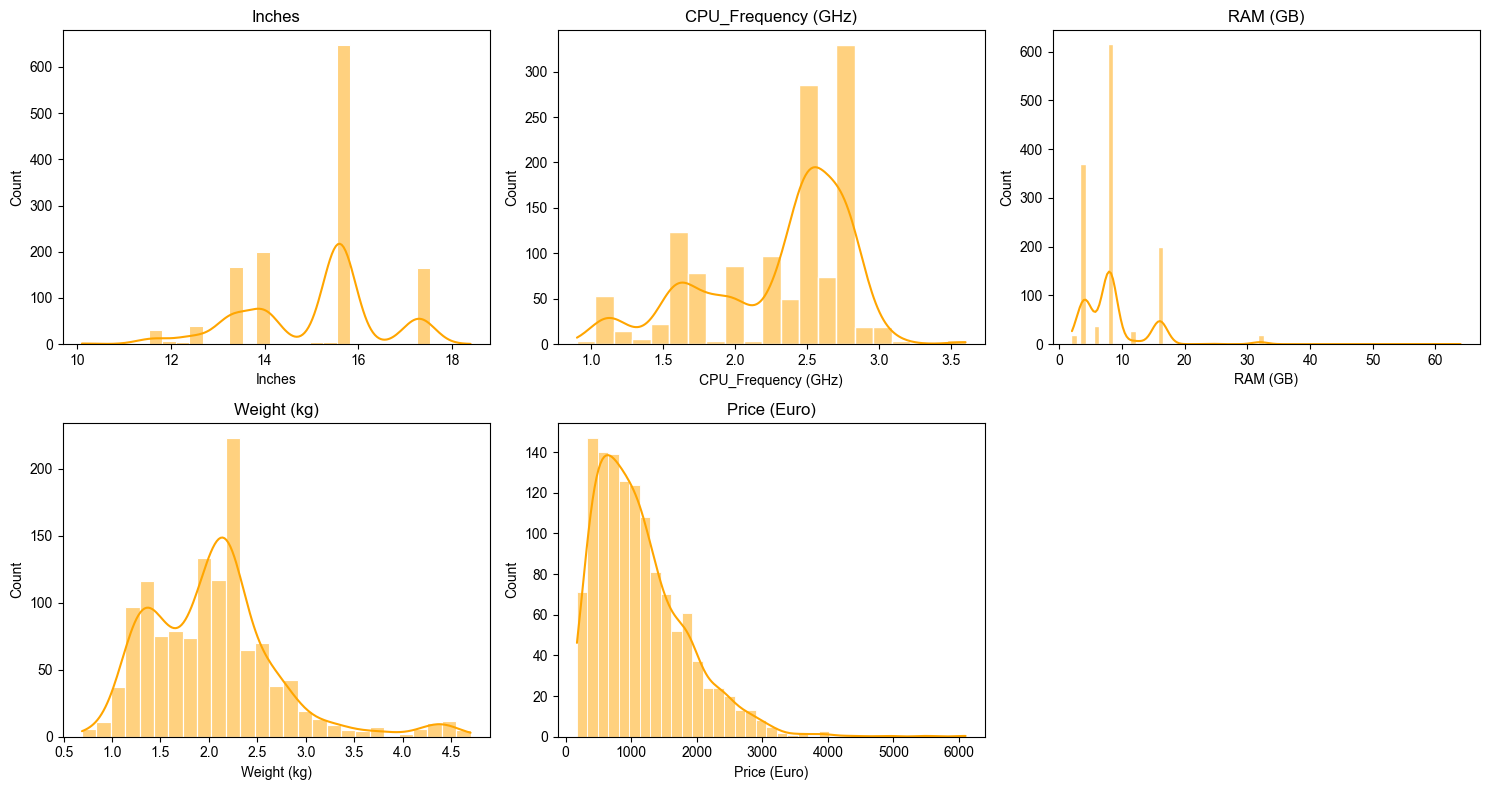

In [11]:
num_cols = 3
num_rows = (len(true_numerical_features) + num_cols - 1) // num_cols

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows*4))
sns.set_style('darkgrid')
axes = axes.flatten()

for index, column in enumerate(true_numerical_features):
    sns.histplot(data=laptop_data, x=column, ax=axes[index], kde=True, color='orange')
    axes[index].set_title(column)

for j in range(index + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

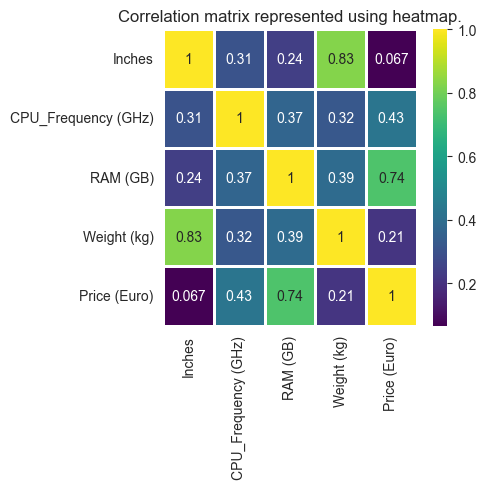

In [12]:
numerical_features = laptop_data[true_numerical_features]

plt.figure(figsize=(5, 5))
sns.heatmap(numerical_features.corr(), annot=True, linewidths=0.8, cmap='viridis')
plt.title("Correlation matrix represented using heatmap.")
plt.tight_layout()
plt.show()

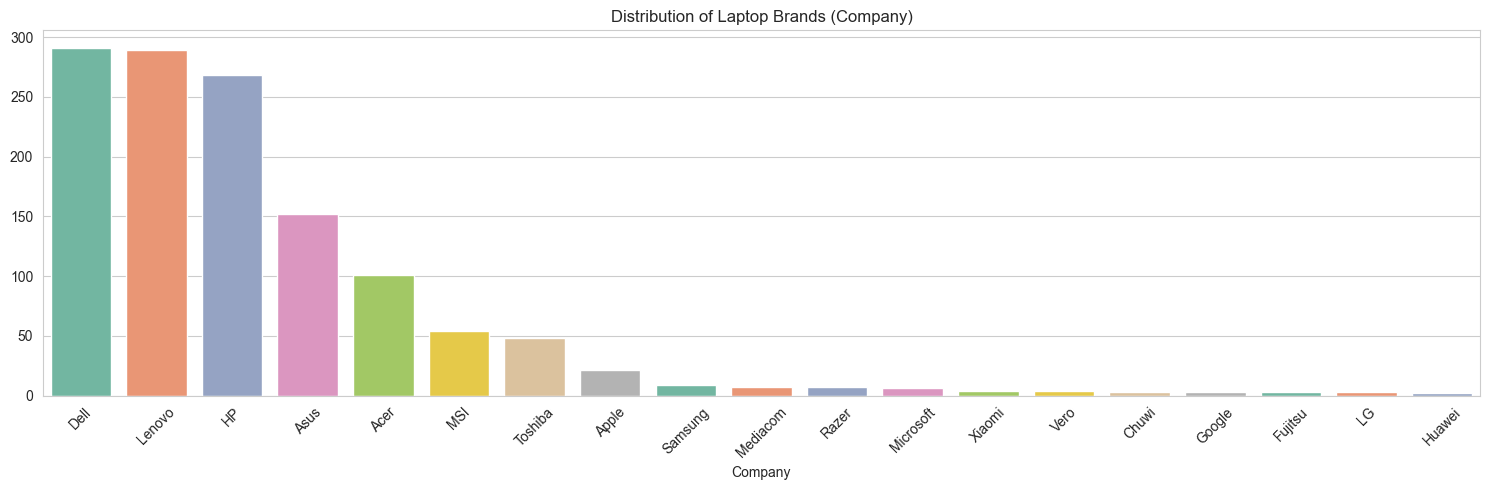

In [13]:
plt.figure(figsize=(15, 5))
sns.set_style('whitegrid')
sorted_company_data = laptop_data['Company'].value_counts().sort_values(ascending=False)
sns.barplot(x=sorted_company_data.index, y=sorted_company_data.values, palette='Set2')
plt.title('Distribution of Laptop Brands (Company)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

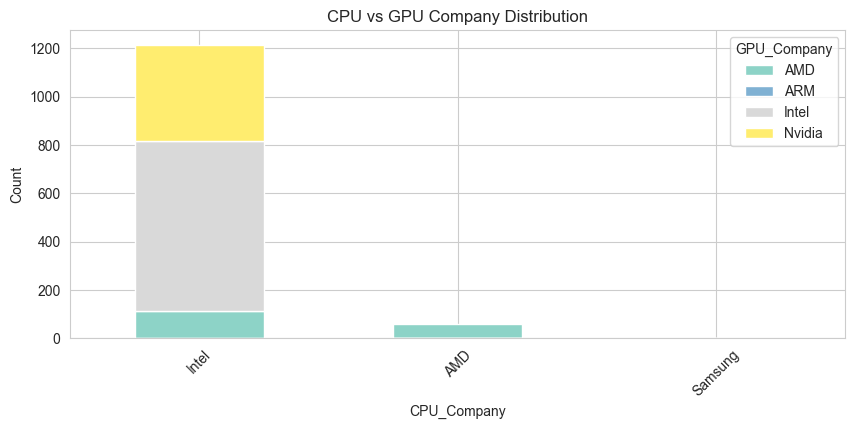

In [14]:
crosstab_cpu_gpu = pd.crosstab(laptop_data['CPU_Company'], laptop_data['GPU_Company'])
crosstab_cpu_gpu = crosstab_cpu_gpu.loc[crosstab_cpu_gpu.sum(axis=1).sort_values(ascending=False).index]
crosstab_cpu_gpu.plot(kind='bar', stacked=True, figsize=(10, 4), colormap='Set3')
plt.xticks(rotation=45)
plt.title('CPU vs GPU Company Distribution')
plt.ylabel('Count')
plt.show()

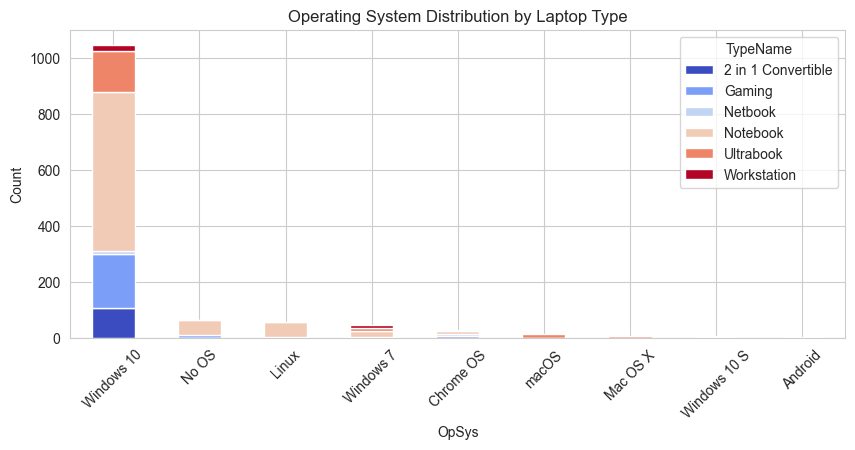

In [15]:
crosstab_os_type = pd.crosstab(laptop_data['OpSys'], laptop_data['TypeName'])
crosstab_os_type = crosstab_os_type.loc[crosstab_os_type.sum(axis=1).sort_values(ascending=False).index]
crosstab_os_type.plot(kind='bar', stacked=True, figsize=(10, 4), colormap='coolwarm')
plt.xticks(rotation=45)
plt.title('Operating System Distribution by Laptop Type')
plt.ylabel('Count')
plt.show()

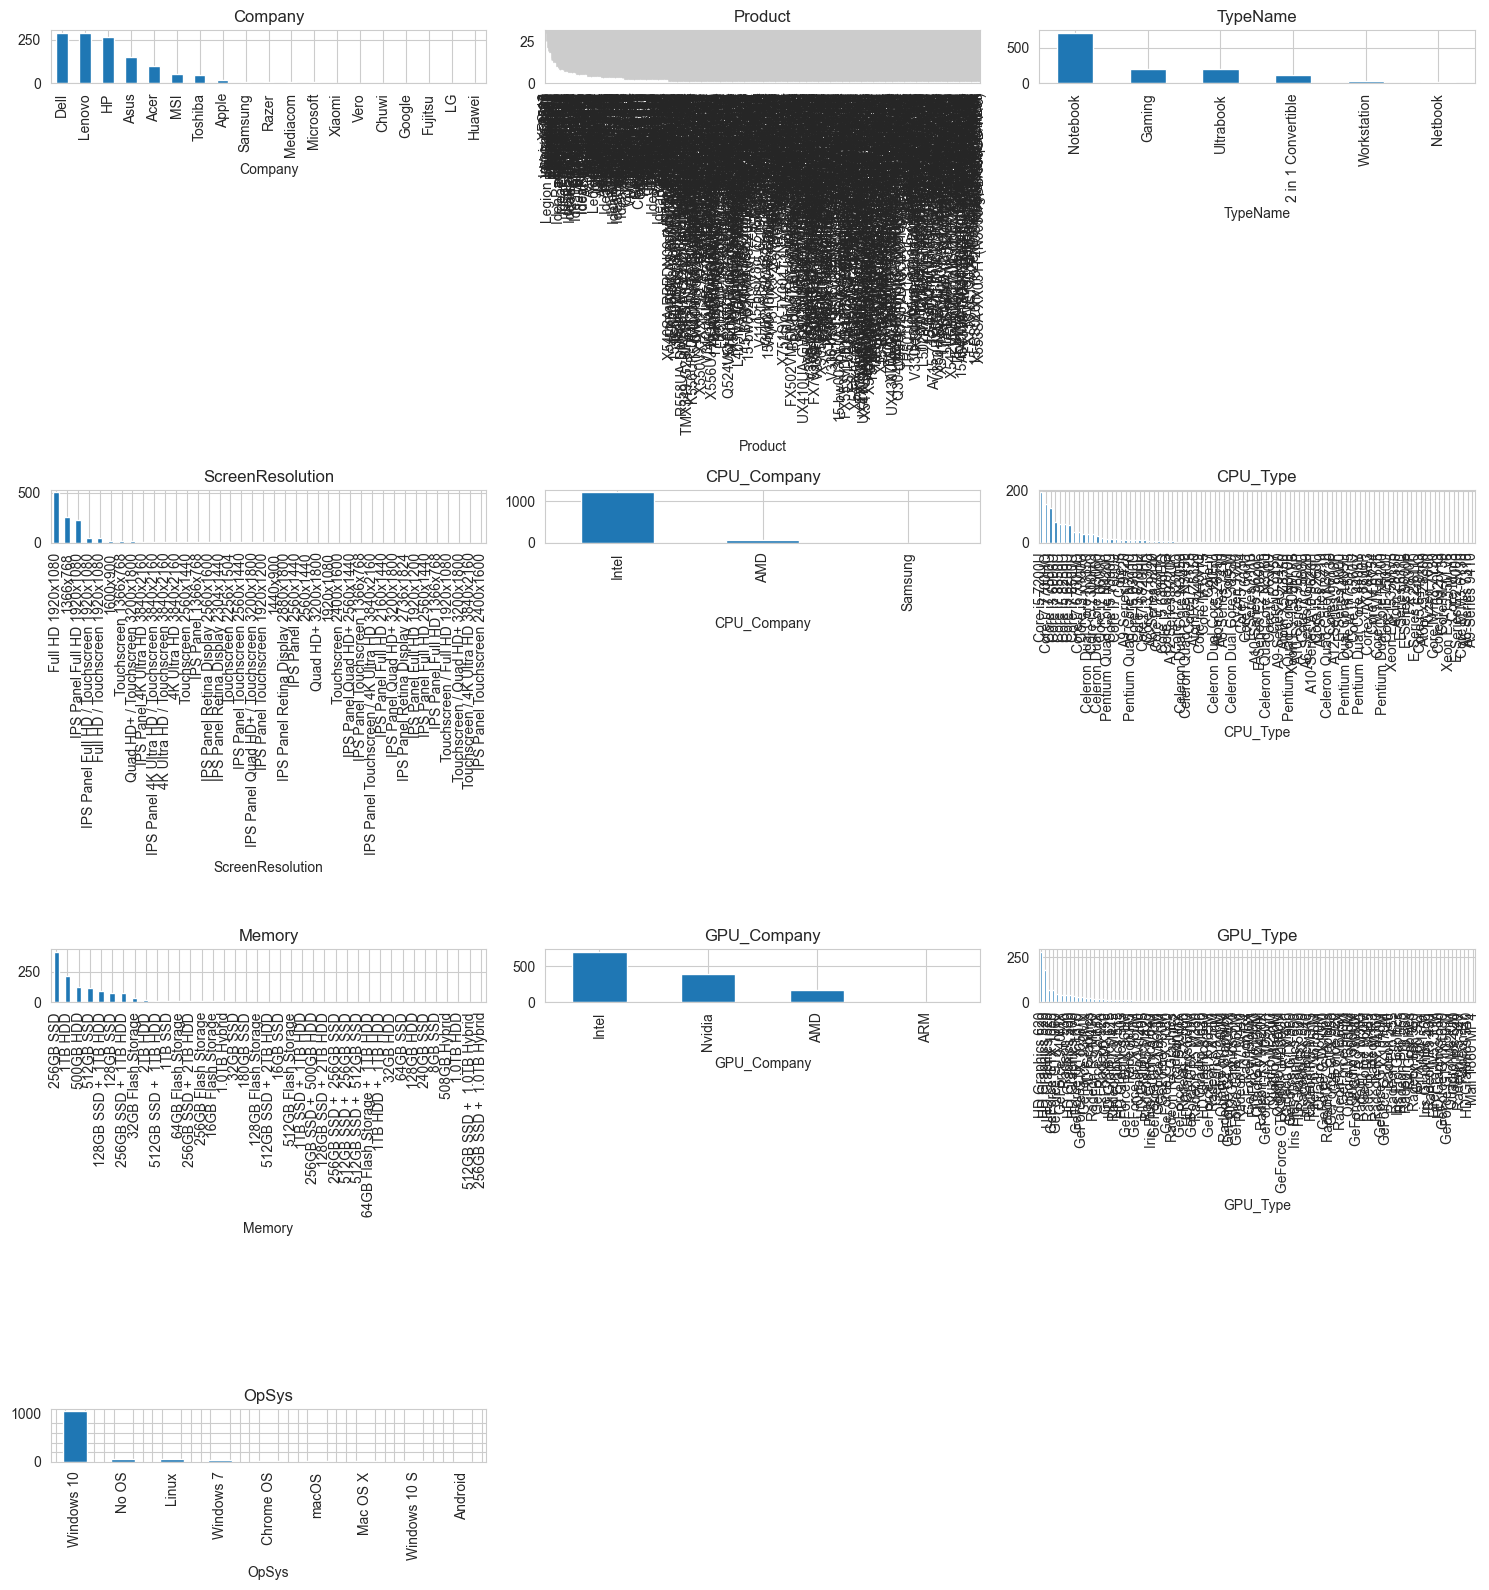

In [16]:
categorical_features = laptop_data.select_dtypes(include='object').columns

num_cols = 3
num_rows = (len(categorical_features) + num_cols - 1) // num_cols

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows*4))
axes = axes.flatten()

for index, column in enumerate(categorical_features):
    laptop_data[column].value_counts().plot(kind='bar', ax=axes[index])
    axes[index].set_title(column)

for j in range(index + 1, len(axes)):
    fig.delaxes(axes[j])

plt.minorticks_on()
plt.grid(which='both')
plt.tight_layout()
plt.show()

In [17]:
for column in laptop_data.select_dtypes(include='object').columns:
    print(f'Feature {column} has {laptop_data[column].nunique()} values. They are: {laptop_data[column].unique()}\n')

Feature Company has 19 values. They are: ['Apple' 'HP' 'Acer' 'Asus' 'Dell' 'Lenovo' 'Chuwi' 'MSI' 'Microsoft'
 'Toshiba' 'Huawei' 'Xiaomi' 'Vero' 'Razer' 'Mediacom' 'Samsung' 'Google'
 'Fujitsu' 'LG']

Feature Product has 618 values. They are: ['MacBook Pro' 'Macbook Air' '250 G6' 'Aspire 3' 'ZenBook UX430UN'
 'Swift 3' 'Inspiron 3567' 'MacBook 12"' 'IdeaPad 320-15IKB' 'XPS 13'
 'Vivobook E200HA' 'Legion Y520-15IKBN' '255 G6' 'Inspiron 5379'
 '15-BS101nv (i7-8550U/8GB/256GB/FHD/W10)' 'MacBook Air' 'Inspiron 5570'
 'Latitude 5590' 'ProBook 470' 'LapBook 15.6"'
 'E402WA-GA010T (E2-6110/2GB/32GB/W10)'
 '17-ak001nv (A6-9220/4GB/500GB/Radeon' 'IdeaPad 120S-14IAP'
 'Inspiron 5770' 'ProBook 450' 'X540UA-DM186 (i3-6006U/4GB/1TB/FHD/Linux)'
 'Inspiron 7577' 'X542UQ-GO005 (i5-7200U/8GB/1TB/GeForce'
 'Aspire A515-51G' 'Inspiron 7773' 'IdeaPad 320-15ISK' 'Rog Strix'
 'X751NV-TY001T (N4200/4GB/1TB/GeForce' 'Yoga Book' 'ProBook 430'
 'Inspiron 3576' '15-bs002nv (i3-6006U/4GB/128GB/FHD/W10)' 'VivoBo

In [18]:
numerical_data = laptop_data.select_dtypes(include="number")
vif_data = pd.DataFrame()
vif_data["features"] = numerical_data.columns
vif_data["VIF"] = [vif(numerical_data.values, i) for i in range(numerical_data.shape[1])]
vif_data.sort_values(by="VIF", ascending=False, inplace=True)
vif_data

,features,VIF
0,Inches,41.4784
1,CPU_Frequency (GHz),29.4509
3,Weight (kg),19.3752
2,RAM (GB),9.4724
4,Price (Euro),8.9299


In [19]:
laptop_data.drop(labels='Inches', axis=1, inplace=True)
true_numerical_features.remove('Inches')
numerical_data = laptop_data.select_dtypes(include="number")
vif_data = pd.DataFrame()
vif_data["features"] = numerical_data.columns
vif_data["VIF"] = [vif(numerical_data.values, i) for i in range(numerical_data.shape[1])]
vif_data.sort_values(by="VIF", ascending=False, inplace=True)
vif_data

,features,VIF
0,CPU_Frequency (GHz),13.0722
2,Weight (kg),11.5998
1,RAM (GB),9.4414
3,Price (Euro),8.8572


In [20]:
laptop_data.drop(labels='CPU_Frequency (GHz)', axis=1, inplace=True)
true_numerical_features.remove('CPU_Frequency (GHz)')
numerical_data = laptop_data.select_dtypes(include="number")
vif_data = pd.DataFrame()
vif_data["features"] = numerical_data.columns
vif_data["VIF"] = [vif(numerical_data.values, i) for i in range(numerical_data.shape[1])]
vif_data.sort_values(by="VIF", ascending=False, inplace=True)
vif_data

,features,VIF
0,RAM (GB),9.3831
2,Price (Euro),7.5466
1,Weight (kg),4.4216


In [21]:
label_encoder = LabelEncoder()

categorical_features = laptop_data.select_dtypes(include='object').columns
for feature in categorical_features:
    laptop_data[feature] = label_encoder.fit_transform(laptop_data[feature])

In [22]:
display(laptop_data.head(2))
display(laptop_data.tail(2))

,Company,Product,TypeName,ScreenResolution,CPU_Company,CPU_Type,RAM (GB),Memory,GPU_Company,GPU_Type,OpSys,Weight (kg),Price (Euro)
0,1,300,4,23,1,40,8,4,2,56,8,1.3700,1339.6900
1,1,301,4,1,1,40,8,2,2,50,8,1.3400,898.9400


,Company,Product,TypeName,ScreenResolution,CPU_Company,CPU_Type,RAM (GB),Memory,GPU_Company,GPU_Type,OpSys,Weight (kg),Price (Euro)
1273,7,2,3,0,1,55,6,10,0,88,5,2.1900,764.0000
1274,2,568,3,0,1,20,4,26,2,39,5,2.2000,369.0000


In [23]:
standard_scaler = StandardScaler()

laptop_features = laptop_data.columns
laptop_data = standard_scaler.fit_transform(laptop_data)
laptop_data = pd.DataFrame(data=laptop_data, columns=laptop_features)
display(laptop_data.head(2))
display(laptop_data.tail(2))

,Company,Product,TypeName,ScreenResolution,CPU_Company,CPU_Type,RAM (GB),Memory,GPU_Company,GPU_Type,OpSys,Weight (kg),Price (Euro)
0,-1.3335,-0.0429,1.1361,1.7377,0.2165,-0.6039,-0.0865,-1.5492,-0.0398,0.3350,3.0814,-1.0024,0.2923
1,-1.3335,-0.0370,1.1361,-1.0562,0.2165,-0.6039,-0.0865,-1.8013,-0.0398,0.1045,3.0814,-1.0472,-0.3370


,Company,Product,TypeName,ScreenResolution,CPU_Company,CPU_Type,RAM (GB),Memory,GPU_Company,GPU_Type,OpSys,Weight (kg),Price (Euro)
1273,0.1318,-1.7846,0.3345,-1.1832,0.2165,0.2798,-0.4790,-0.7928,-2.2017,1.5646,0.1798,0.2235,-0.5296
1274,-1.0893,1.5235,0.3345,-1.1832,0.2165,-1.7820,-0.8715,1.2243,-0.0398,-0.3182,0.1798,0.2384,-1.0935


In [24]:
X = laptop_data.drop(labels='Price (Euro)', axis=1)
y = laptop_data['Price (Euro)']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    shuffle=True, 
                                                    random_state=0)

In [26]:
param_grid = {
    'criterion': ["squared_error", "friedman_mse", "absolute_error", "poisson"],
    'max_depth': range(4, 20, 2),
    'max_features': ['sqrt', 'log2', None],
    'n_estimators': range(100, 500, 100),
    'min_samples_split': [2, 5, 10, 15], 
    'min_samples_leaf': [1, 2, 5, 10]
}

k_fold_cv = KFold(n_splits=5, shuffle=True, random_state=0)

random_forest_regressor = RandomForestRegressor()

randomised_search_cv = RandomizedSearchCV(estimator=random_forest_regressor, 
                                          param_distributions=param_grid, 
                                          random_state=0, 
                                          cv=3,
                                          n_jobs=-1,
                                          n_iter=30)

randomised_search_cv.fit(X_train, y_train)

best_rfr_model = randomised_search_cv.best_estimator_
best_parameters = randomised_search_cv.best_params_
print(f"Best parameters are: {best_parameters}")

Best parameters are: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 14, 'criterion': 'friedman_mse'}


In [27]:
y_train_pred = best_rfr_model.predict(X_train)
y_test_pred = best_rfr_model.predict(X_test)

train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train Root Mean Squared Error: {train_rmse:.2f}")
print(f"Test Root Mean Squared Error: {test_rmse:.2f}")
print(f"Test R-squared Score: {test_r2:.2f}")

Train Root Mean Squared Error: 0.17
Test Root Mean Squared Error: 0.46
Test R-squared Score: 0.82


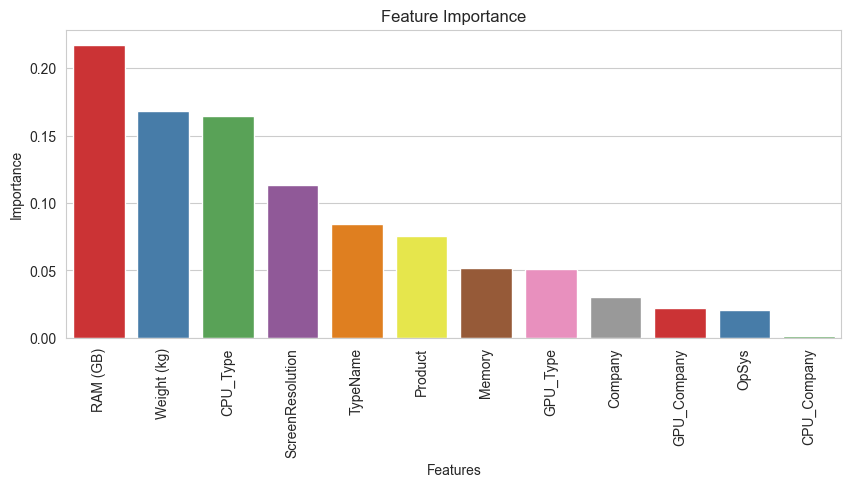

In [28]:
importance = best_rfr_model.feature_importances_
importance_df = pd.DataFrame([X.columns, importance], index=["Features", "Importance"]).T
importance_df.sort_values(by='Importance', ascending=False, inplace=True)
plt.figure(figsize=(10, 4))
sns.barplot(data=importance_df, x='Features', y='Importance', palette="Set1")
plt.xticks(rotation=90)
plt.title("Feature Importance")
plt.show()

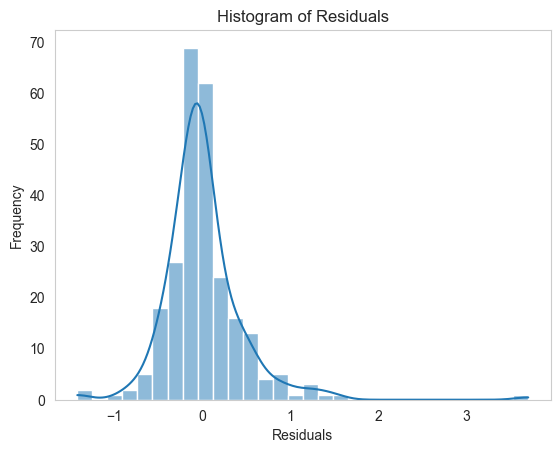

In [29]:
residuals = y_test - y_test_pred

sns.histplot(residuals, bins=30, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.grid()
plt.show()

In [30]:
residuals.skew()

2.447464062696908

In [31]:
y_test_pred_padded = np.zeros((255, 13))
y_test_pred_padded[:, -1] = y_test_pred.flatten()
y_test_pred_original = standard_scaler.inverse_transform(y_test_pred_padded)
y_test_pred = y_test_pred_original[:, -1]

In [32]:
submission_dataframe = pd.DataFrame({
    'Index': X_test.index,
    'Price (Euros)': y_test_pred
})

submission_dataframe.sort_values(by="Index", inplace=True)
display(submission_dataframe.head(2))
display(submission_dataframe.tail(2))

,Index,Price (Euros)
68,1,1187.8163
15,5,397.5690


,Index,Price (Euros)
108,1259,1270.6344
73,1268,266.2179


In [33]:
submission_dataframe_file = '../d. Output Files/LaptopPrice/' + 'LaptopPrice_Prediction.csv'
print(f"File name: {submission_dataframe_file.split('/')[3]}")
submission_dataframe.to_csv(submission_dataframe_file, index=False)

File name: LaptopPrice_Prediction.csv
